<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Sprint Challenge
## *Data Science Unit 4 Sprint 1*

After a week of Natural Language Processing, you've learned some cool new stuff: how to process text, how turn text into vectors, and how to model topics from documents. Apply your newly acquired skills to one of the most famous NLP datasets out there: [Yelp](https://www.yelp.com/dataset/challenge). As part of the job selection process, some of my friends have been asked to create analysis of this dataset, so I want to empower you to have a head start.  

The real dataset is massive (almost 8 gigs uncompressed). I've sampled the data for you to something more managable for the Sprint Challenge. You can analyze the full dataset as a stretch goal or after the sprint challenge. As you work on the challenge, I suggest adding notes about your findings and things you want to analyze in the future.

## Challenge Objectives
*Successfully complete these all these objectives to earn a 2. There are more details on each objective further down in the notebook.*
* <a href="#p1">Part 1</a>: Write a function to tokenize the yelp reviews
* <a href="#p2">Part 2</a>: Create a vector representation of those tokens
* <a href="#p3">Part 3</a>: Use your tokens in a classification model on yelp rating
* <a href="#p4">Part 4</a>: Estimate & Interpret a topic model of the Yelp reviews

In [1]:
import pandas as pd

yelp = pd.read_json('./data/review_sample.json', lines=True)

In [2]:
yelp.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,nDuEqIyRc8YKS1q1fX0CZg,1,2015-03-31 16:50:30,0,eZs2tpEJtXPwawvHnHZIgQ,1,"BEWARE!!! FAKE, FAKE, FAKE....We also own a sm...",10,n1LM36qNg4rqGXIcvVXv8w
1,eMYeEapscbKNqUDCx705hg,0,2015-12-16 05:31:03,0,DoQDWJsNbU0KL1O29l_Xug,4,Came here for lunch Togo. Service was quick. S...,0,5CgjjDAic2-FAvCtiHpytA
2,6Q7-wkCPc1KF75jZLOTcMw,1,2010-06-20 19:14:48,1,DDOdGU7zh56yQHmUnL1idQ,3,I've been to Vegas dozens of times and had nev...,2,BdV-cf3LScmb8kZ7iiBcMA
3,k3zrItO4l9hwfLRwHBDc9w,3,2010-07-13 00:33:45,4,LfTMUWnfGFMOfOIyJcwLVA,1,We went here on a night where they closed off ...,5,cZZnBqh4gAEy4CdNvJailQ
4,6hpfRwGlOzbNv7k5eP9rsQ,1,2018-06-30 02:30:01,0,zJSUdI7bJ8PNJAg4lnl_Gg,4,"3.5 to 4 stars\n\nNot bad for the price, $12.9...",5,n9QO4ClYAS7h9fpQwa5bhA


## Part 1: Tokenize Function
<a id="#p1"></a>

Complete the function `tokenize`. Your function should
- accept one document at a time
- return a list of tokens

You are free to use any method you have learned this week.

In [6]:
import spacy
from spacy.tokenizer import Tokenizer

In [7]:
# I assume that instruction is a typo, and doesn't expect me to write a function which is already a document, rather than plain text.

nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

def tokenize(text):
    return [token.lemma_ for token in nlp(text) if (token.is_stop != True) and (token.is_punct != True)]

In [3]:
# For the sake of time, I'm using this instead
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

C:\Users\soobt\Anaconda3\envs\jupyterlab\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Part 2: Vector Representation
<a id="#p2"></a>
1. Create a vector representation of the reviews
2. Write a fake review and query for the 10 most similiar reviews, print the text of the reviews. Do you notice any patterns?
    - Given the size of the dataset, it will probably be best to use a `NearestNeighbors` model for this. 

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(stop_words='english', min_df=0.05, max_df=.98)
dtm = vect.fit_transform(yelp['text'].values)
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

In [12]:
dtm.head()

,10,amazing,area,asked,away,awesome,bad,bar,best,better,...,vegas,wait,want,wanted,wasn,way,went,work,worth,years
0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,...,0.000000,0.392384,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.14922,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,...,0.292434,0.000000,0.0,0.0,0.0,0.0,0.123145,0.0,0.0,0.0
3,0.0,0.0,0.00000,0.0,0.0,0.0,0.00000,0.000000,0.360664,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.381265,0.0,0.0,0.0
4,0.0,0.0,0.00000,0.0,0.0,0.0,0.23316,0.466138,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [14]:
from sklearn.neighbors import NearestNeighbors

nn  = NearestNeighbors(n_neighbors=10, algorithm='ball_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=10, p=2, radius=1.0)

In [25]:
review = "This place was disgusting! Food was inedible, and the place was filthy. The owners should be ashamed."

sims = nn.kneighbors(vect.transform([review]).todense())[1]

In [30]:
for t in yelp['text'].iloc[sims[0]].values:
    print(t, '\n')

Food is awful. Very disappointing because this place has such potential, but the awkward presentation and bland food makes this a place to avoid. 

Been to car washes in most of the Eastern and Midwestern states... And this place rates at the Top. The Owner works the operations... And it shows! 

Fun place with the family. Literally "hand made" noodles.  Plus the serving size was gigantic! 

Ok place. Kindof outdated tanning bed but it served it's purpose. 2 bulbs were burnt out. Whatdya expect for 6 bucks though... 

SAQ is certainly bigger than the average liquor shops I go to in the states. Wine & Hard Alcohol galore, but incredibly limited beer selection. (I haven't purchased much alcohol in Montreal, but I do prefer IGA's beer selections). Credit cards are accepted. Apparently its fine to walk out of the store & around Montreal without placing liquor in a bag. who knew! In general, its expensive to purchase alcohol in montreal so I was quite satisfied with this place. They had wha

They are mostly bad, like my input review.

## Part 3: Classification
<a id="#p3"></a>
Your goal in this section will be to predict `stars` from the review dataset. 

1. Create a piepline object with a sklearn `CountVectorizer` or `TfidfVector` and any sklearn classifier. Use that pipeline to estimate a model to predict `stars`. Use the Pipeline to predict a star rating for your fake review from Part 2. 
2. Tune the entire pipeline with a GridSearch

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

vect = TfidfVectorizer(stop_words='english')
rfc = RandomForestClassifier(n_estimators=100)

pipe = Pipeline([('vect', vect), ('rfc', rfc)])

In [5]:
X = yelp['text'].values
y = yelp['stars'].values

In [37]:
pipe.fit(X, y)

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [41]:
pipe.predict([review])

array([5], dtype=int64)

Hmm... seems like the opposite of this should be true.

In [8]:
from sklearn.model_selection import GridSearchCV

In [52]:
parameters = {
    'vect__max_df': ( 0.75, 1.0),
    'vect__min_df': (.02, .05),
    'vect__max_features': (500,1000),
    'rfc__n_estimators':(5, 10,100),
    'rfc__max_depth':(15,20)
}

grid_search = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  3.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vect__max_df': (0.75, 1.0), 'vect__min_df': (0.02, 0.05), 'vect__max_features': (500, 1000), 'rfc__n_estimators': (5, 10, 100), 'rfc__max_depth': (15, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [54]:
grid_search.best_score_

0.5561

In [55]:
grid_search.predict([review])

array([5], dtype=int64)

Not great.

In [6]:
# Let's try a different vectorization method
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words='english')
rfc = RandomForestClassifier(n_estimators=100)

pipe = Pipeline([('vect', vect), ('rfc', rfc)])

In [9]:
parameters = {
    'vect__max_df': ( 0.75, 1.0),
    'vect__min_df': (.02, .05),
    'vect__max_features': (500,1000),
    'rfc__n_estimators':(5, 10,100),
    'rfc__max_depth':(15,20)
}

grid_search = GridSearchCV(pipe, parameters, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X, y)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  4.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        ...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'vect__max_df': (0.75, 1.0), 'vect__min_df': (0.02, 0.05), 'vect__max_features': (500, 1000), 'rfc__n_estimators': (5, 10, 100), 'rfc__max_depth': (15, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [10]:
grid_search.best_score_

0.5535

In [13]:
grid_search.predict([review])

array([5], dtype=int64)

Wow, almost identically bad.

## Part 4: Topic Modeling

Let's find out what those yelp reviews are saying! :D

1. Estimate a LDA topic model of the review text
    - Keep the `iterations` parameter at or below 5 to reduce run time
    - The `workers` parameter should match the number of physical cores on your machine.
2. Create 1-2 visualizations of the results
    - You can use the most important 3 words of a topic in relevant visualizations. Refer to yesterday's notebook to extract. 
3. In markdown, write 1-2 paragraphs of analysis on the results of your topic model

__*Note*__: You can pass the DataFrame column of text reviews to gensim. You do not have to use a generator.

In [4]:
from gensim.models import LdaMulticore
from gensim.corpora import Dictionary

Learn the vocubalary of the yelp data:

In [5]:
yelp['tokens'] = yelp['text'].apply(tokenize)

In [6]:
from gensim import corpora

id2word = corpora.Dictionary(yelp['tokens'])

Create a bag of words representation of the entire corpus

In [7]:
corpus = [id2word.doc2bow(text) for text in yelp['tokens']]

Your LDA model should be ready for estimation: 

In [8]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   iterations=5,
                   workers=4,
                   num_topics = 5 # You can change this parameter
                  )

Create 1-2 visualizations of the results

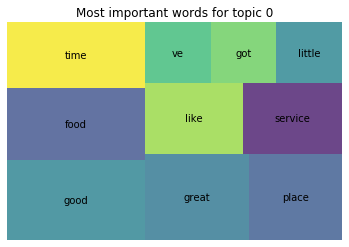

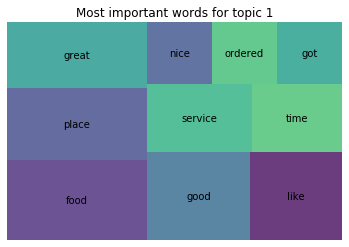

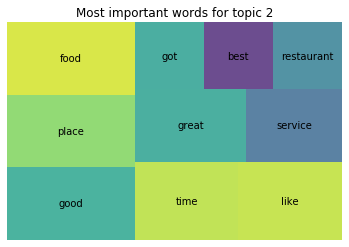

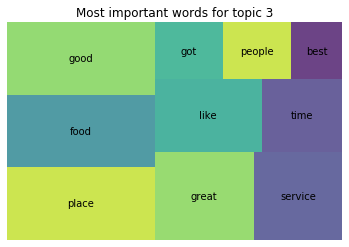

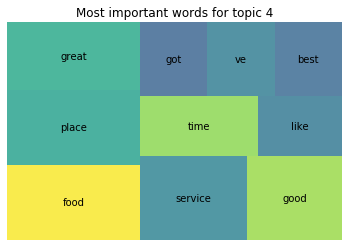

In [17]:
import squarify
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import re

def flatten(l):
    return [item for sublist in l for item in sublist]

num_topics = 5

words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]
coefs = [list(map(float, re.findall(r'\d\.\d\d\d',t[1]))) for t in lda.print_topics()]

topicDf = pd.DataFrame()
topicDf['topics'] = [ i for i in range(5) for _ in range(10)]
topicDf['coefs'] = flatten(coefs)
topicDf['words'] = flatten(words)

for i in range(num_topics):
    topic = topicDf[topicDf['topics'] == i]['coefs']
    topic_labels = topicDf[topicDf['topics'] == i]['words']

    squarify.plot(sizes=topic, label=topic_labels, alpha=.8 )
    plt.axis('off')
    plt.title('Most important words for topic ' + str(i))
    plt.show()

In [18]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [ ]:
# pyLDAvis.gensim.prepare(lda, corpus, id2word) keeps freezing my notebook, so you'll have to just imagine it.

## Stretch Goals

Complete one of more of these to push your score towards a three: 
* Incorporate named entity recognition into your analysis
* Compare vectorization methods in the classification section
* Analyze more (or all) of the yelp dataset - this one is v. hard. 
* Use a generator object on the reviews file - this would help you with the analyzing the whole dataset.
* Incorporate any of the other yelp dataset entities in your analysis (business, users, etc.)